# Example Notebook for measuring performance and accuracy

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, '../')

import blink
from importlib import reload
reload(blink)

import pandas as pd
import numpy as np
import scipy
from scipy import sparse as sp

from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Load data

In [2]:
small  = blink.open_msms_file('./small.mgf')
medium = blink.open_msms_file('./medium.mgf')

S1 = blink.discretize_spectra(small.spectrum,  small.precursor_mz,  intensity_power=0.5)
S2 = blink.discretize_spectra(medium.spectrum, medium.precursor_mz, intensity_power=0.5)

# Run BLINK on 1 million comparisons

In [3]:
%%time
S12 = blink.score_sparse_spectra(S1, S2, tolerance=0.01)

CPU times: user 91 ms, sys: 14.8 ms, total: 106 ms
Wall time: 105 ms


# Run MatchMS for same comparisons

In [4]:
import matchms as mms
from matchms.similarity import CosineGreedy, ModifiedCosine

MMS1 = [mms.Spectrum(s.spectrum[0],
                     s.spectrum[1],
                     metadata={'precursor_mz': s.precursor_mz}) 
        for i,s in small.iterrows()]
MMS2 = [mms.Spectrum(m.spectrum[0],
                     m.spectrum[1],
                     metadata={'precursor_mz': m.precursor_mz}) 
        for i,m in medium.iterrows()]

cos = CosineGreedy(tolerance=0.0099,intensity_power=0.5)
mod = ModifiedCosine(tolerance=0.0099,intensity_power=0.5)

In [5]:
%%time
MMS12 = {}
MMS12['cos'] = cos.matrix(references=MMS1, queries=MMS2)
MMS12['mod'] = mod.matrix(references=MMS1, queries=MMS2)

CPU times: user 1min 32s, sys: 259 ms, total: 1min 32s
Wall time: 1min 32s


# Generate Figure in Manuscript

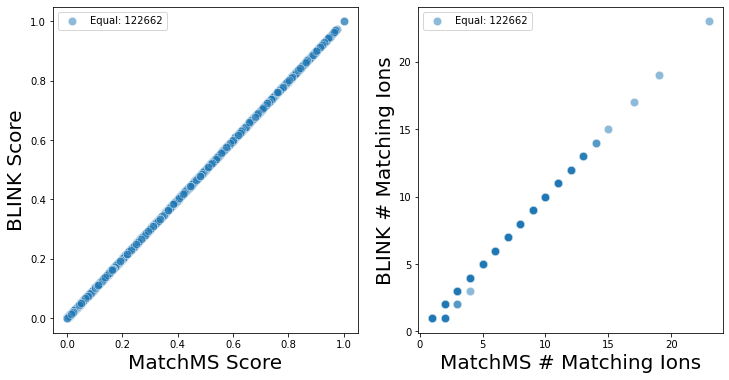

In [6]:
%matplotlib inline
x = MMS12['cos']['score'].flatten()
y = S12['mzi'].toarray().flatten()
x,y = x[(x>0)&(y>0)], y[(x>0)&(y>0)]


fig, ax = plt.subplots(figsize=(12, 6),nrows=1,ncols=2)
ax = ax.flatten()
sns.scatterplot(x=x, y=y, s=70, label='Equal: {}'.format(len(x)), alpha=.5,ax=ax[0])
x,y = x[(y+1e-2<x)|(x<y-1e-2)], y[(x+1e-2<y)|(y<x-1e-2)]
sns.scatterplot(x=x, y=y, s=70, label='Unequal: {}'.format(len(x)),ax=ax[0])
ax[0].set_xlabel('MatchMS Score',fontsize=20)
ax[0].set_ylabel('BLINK Score',fontsize=20)


x = MMS12['cos']['matches'].flatten()
y = S12['mzc'].toarray().flatten()
x,y = x[(x>0)&(y>0)], y[(x>0)&(y>0)]

sns.scatterplot(x=x, y=y, s=70, label='Equal: {}'.format(len(x)), alpha=.5,ax=ax[1])
x,y = x[(y+1<x)|(x<y-1)], y[(x+1<y)|(y<x-1)]
sns.scatterplot(x=x, y=y, s=70, label='Unequal: {}'.format(len(x)),ax=ax[1])
ax[1].set_xlabel('MatchMS # Matching Ions',fontsize=20)
ax[1].set_ylabel('BLINK # Matching Ions',fontsize=20)

fig.savefig('cos_accuracy_benchmarking.pdf')

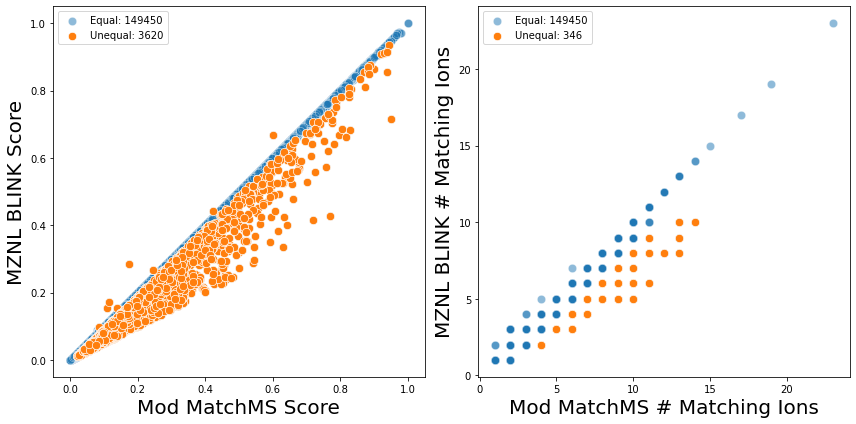

In [7]:
%matplotlib inline
x = MMS12['mod']['score'].flatten()
y = np.maximum(S12['mzi'].toarray().flatten(),S12['nli'].toarray().flatten())
x,y = x[(x>0)&(y>0)], y[(x>0)&(y>0)]


fig, ax = plt.subplots(figsize=(12, 6),nrows=1,ncols=2)
ax = ax.flatten()
sns.scatterplot(x=x, y=y, s=70, label='Equal: {}'.format(len(x)), alpha=.5,ax=ax[0])
x,y = x[(y+1e-2<x)|(x<y-1e-2)], y[(x+1e-2<y)|(y<x-1e-2)]
sns.scatterplot(x=x, y=y, s=70, label='Unequal: {}'.format(len(x)),ax=ax[0])
ax[0].set_xlabel('Mod MatchMS Score',fontsize=20)
ax[0].set_ylabel('MZNL BLINK Score',fontsize=20)


x = MMS12['mod']['matches'].flatten()
y = np.maximum(S12['mzc'].toarray().flatten(),S12['nlc'].toarray().flatten())
x,y = x[(x>0)&(y>0)], y[(x>0)&(y>0)]

sns.scatterplot(x=x, y=y, s=70, label='Equal: {}'.format(len(x)), alpha=.5,ax=ax[1])
x,y = x[(y+1<x)|(x<y-1)], y[(x+1<y)|(y<x-1)]
sns.scatterplot(x=x, y=y, s=70, label='Unequal: {}'.format(len(x)),ax=ax[1])
ax[1].set_xlabel('Mod MatchMS # Matching Ions',fontsize=20)
ax[1].set_ylabel('MZNL BLINK # Matching Ions',fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig('mod_accuracy_benchmarking.pdf')